<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Pre-Training Scheme</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is introducing the pre-training scheme. The functions are contained within the Neural Network file. 
</p>

In [ ]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl")
includet("NeuralNetwork.jl")
using Base.Threads

  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`


In [ ]:
rng = Random.MersenneTwister(42)

fieldd = meshgrid(20, train=false)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(grads_ideal_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend,min_e=1.3, max_e=2.3) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend,min_e=1.3, max_e=2.3) |>f32

x_Train = reshape(x_train, 2, 25*30) #.|>f32
y_Train = reshape(y_train, 2, 25*30) #.|>f32

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

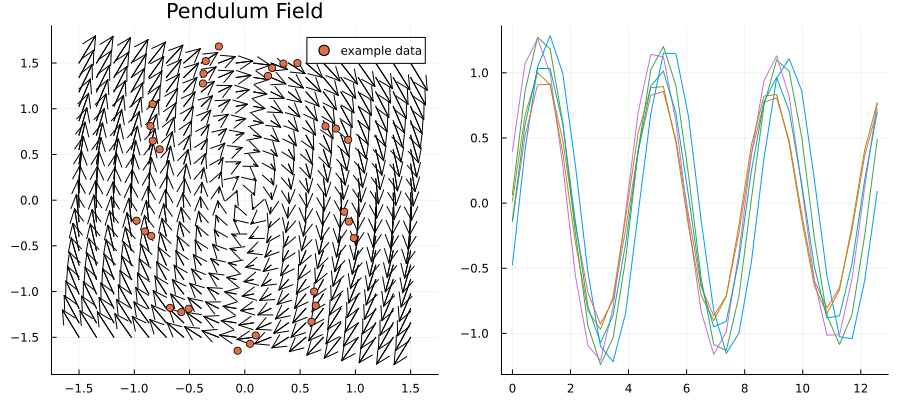

In [ ]:
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 2:7
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

<h2 style="font-family:Times New Roman; font-size:200%">Effect of Pre-training analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We compare the pre-training to the analysis done at the end of the rng seed notebook to see the differences visually first. This helps us understand more what is going on
</p>

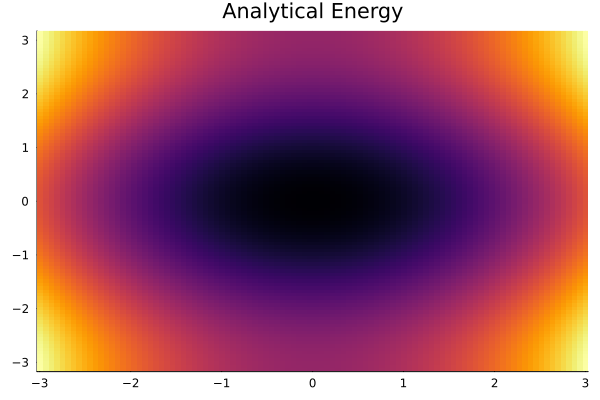

In [8]:
p = range(-3,3,100)
q = range(-pi,pi,100)
p_m = repeat(p, inner=100)
q_m = repeat(q, outer=100)
matrix = hcat(q_m, p_m)' |>f32#Defining the data to find the heatmaps
En = pendulum(matrix[1,:],matrix[2,:]) #This is what the networks are told to fit in the pre-training phase
normalize!(En)
heatmap(p,q, reshape(En, 100, 100),title="Analytical Energy",cbar=false)

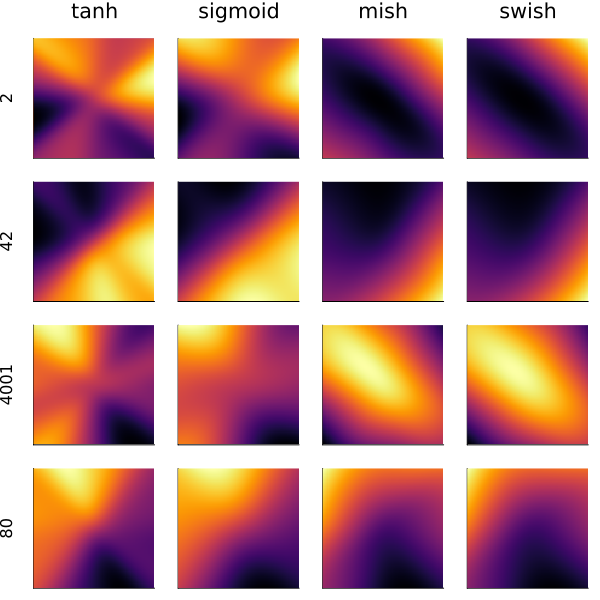

In [9]:
acts = [tanh, sigmoid, mish, swish]
act_str = ["tanh", "sigmoid", "mish", "swish"]
rng_vals = [2, 42, 4001, 80]


_, LuxH_k = models(2, 64, tanh, Kaiming(1),1) #Fetch models
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(1), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
h=heatmap(p,q, reshape(est, 100, 100),layout=(4, 4),cbar=false,size=(600,600))

k=0
for (i,rng) in enumerate(rng_vals)
    for (j, act) in enumerate(acts)
        k+=1 #For plotting
        
        _, LuxH_k = models(2, 64, act, Kaiming(1),1) #Fetch models
        pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(rng), LuxH_k) 
        smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
        est = smodel(matrix)
        
        
        #Placing titles correctly
        if j==1
            y=rng
        else
            y=""
        end
        if i==1
            x=act_str[j]
        else
           x =""
        end
        
        heatmap!(h,p,q, reshape(est, 100, 100),subplot=k,cbar=false,xticks=false,yticks=false,ylabel=y,title=x)
    end
end
display(h)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


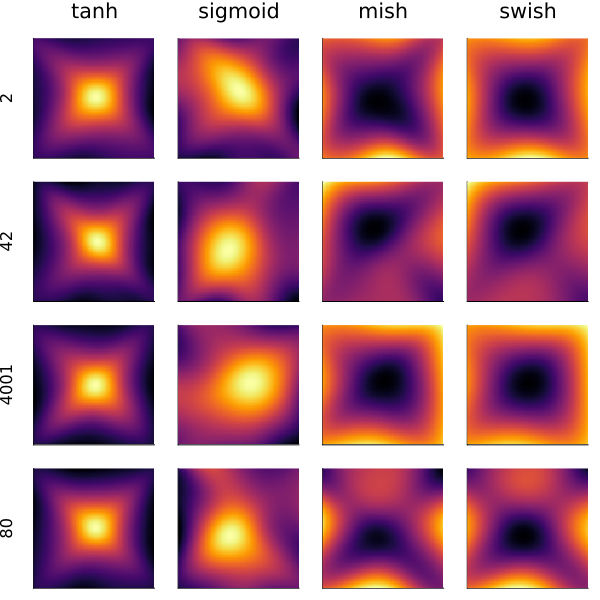

In [18]:
acts = [tanh, sigmoid, mish, swish]
act_str = ["tanh", "sigmoid", "mish", "swish"]
rng_vals = [2, 42, 4001, 80]
_, mod = models(2, 64, tanh, Kaiming(1),1) #Fetch models
ps, st = Lux.setup(Random.MersenneTwister(1), mod)
ps, st = Pre_training(mod, ps, st,iters=100)
smodel = StatefulLuxLayer{true}(mod, ps, st)
est = smodel(matrix)
h=heatmap(p,q, reshape(est, 100, 100),layout=(4, 4),cbar=false,size=(600,600))
k=0
for (i,rng) in enumerate(rng_vals)
    for (j, act) in enumerate(acts)
        k+=1
        println((i,j))
        _, mod = models(2, 64, act, Kaiming(1),1) #Fetch models
        ps, st = Lux.setup(Random.MersenneTwister(rng), mod) 
        ps, st = Pre_training(mod, ps, st)
        smodel = StatefulLuxLayer{true}(mod, ps, st)
        est = smodel(matrix)
        if j==1
            y=rng
        else
            y=""
        end
        if i==1
            x=act_str[j]
        else
           x =""
        end
        
        heatmap!(h,p,q, reshape(est, 100, 100),subplot=k,cbar=false,xticks=false,yticks=false,ylabel=y,title=x)
    end
end
display(h)

<p style="font-family:Times New Roman; font-size:120%">
    The pre-training clearly attempts to de-polarize th network output, very consistently for these few examples, we will see how well it fares!
</p>

Epoch=200 :loss = 0.016930096
Epoch=400 :loss = 0.00079787825
Epoch=600 :loss = 0.0004987137
Epoch=800 :loss = 0.00046117065
Epoch=1000 :loss = 0.00045551534
Epoch=200 :loss = 0.0021346356
Epoch=200 :loss = 0.0017388905
Epoch=200 :loss = 0.0027256259
Epoch=200 :loss = 0.010667836
Epoch=200 :loss = 0.0020355554
Epoch=200 :loss = 0.002349921
Epoch=200 :loss = 0.0039415257
Epoch=200 :loss = 0.011154712
Epoch=200 :loss = 0.0019224599
Epoch=200 :loss = 0.0021394305
Epoch=200 :loss = 0.0030816845
Epoch=200 :loss = 0.01290988
Epoch=200 :loss = 0.0020611796
Epoch=200 :loss = 0.0030551243
Epoch=200 :loss = 0.0023969377


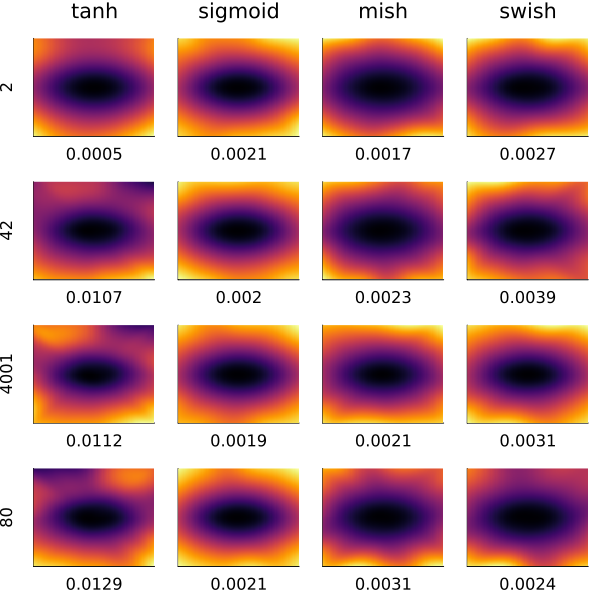

In [19]:
acts = [tanh, sigmoid, mish, swish]
act_str = ["tanh", "sigmoid", "mish", "swish"]
rng_vals = [2, 42, 4001, 80]

_, LuxH = models(2, 64, tanh, Kaiming(1),1) #Fetch models
pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=2,pretrain=true)
smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
h=heatmap(p,q, reshape(est, 100, 100),layout=(4, 4),cbar=false,size=(600,600),
    xticks=false,yticks=false,title="tanh",ylabel=2,xlabel=round(lossHNN(LuxH,x_test, pHNN, sHNN, y_test),digits=4))
k=0
for (i,rng) in enumerate(rng_vals)
    for (j, act) in enumerate(acts)
        k+=1
        if i+j!=2
            _, LuxH = models(2, 64, act, Kaiming(2^0.5),1) #Fetch models
            pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=rng,pretrain=true)
            smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
            est = smodel(matrix)
            if j==1
                y=rng
            else
                y=""
            end
            if i==1
                x=act_str[j]
            else
               x =""
            end

            heatmap!(h,p,q, reshape(est, 100, 100),subplot=k,
                cbar=false,xticks=false,yticks=false,
                ylabel=y,title=x,xlabel=round(lossHNN(LuxH,x_test, pHNN, sHNN, y_test),digits=4))
        end
    end
end
display(h)

In [28]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.1, .5, 1, 2^0.5, 5/3,2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]

MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))

    
    
Threads.@threads for a_idx in 1:length(activations)#for (a_idx, act) in enumerate(activations)
    act=activations[a_idx]
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),1)

        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001, pretrain=true)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk

        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001,pretrain=true)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg

        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001,pretrain=true)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso

    end
end

Doing gelu | Gain 1.4142135623730951
Doing gelu | Gain 2.0
Doing swish | Gain 1.6666666666666667
Doing sigmoid | Gain 2.0
Doing sigmoid | Gain 1.4142135623730951
Doing mish | Gain 0.5
Doing sigmoid | Gain 5.0
Doing gelu | Gain 5.0
Doing tanh | Gain 1.0
Doing swish | Gain 1.4142135623730951
Doing mish | Gain 0.1
Doing mish | Gain 2.0
Epoch=200 :loss = 0.0015615755
Epoch=400 :loss = 0.00053317123
Epoch=200 :loss = 0.0019349322
Epoch=600 :loss = 0.0004706724
Epoch=200 :loss = 0.0022816248
Epoch=200 :loss = 0.08073061
Epoch=400 :loss = 0.0006706369
Epoch=800 :loss = 0.0004283003
Epoch=400 :loss = 0.0007849984
Epoch=400 :loss = 0.0053838626
Epoch=600 :loss = 0.0005200609
Epoch=1000 :loss = 0.00040482858
Epoch=200 :loss = 0.0012729029
Epoch=600 :loss = 0.0006595964
Epoch=600 :loss = 0.0020016395
Epoch=200 :loss = 0.003042288
Epoch=800 :loss = 0.0004985926
Epoch=800 :loss = 0.0006163018
Epoch=400 :loss = 0.0005904033
Epoch=800 :loss = 0.0009930818
Epoch=1000 :loss = 0.00049625756
Epoch=400 :l

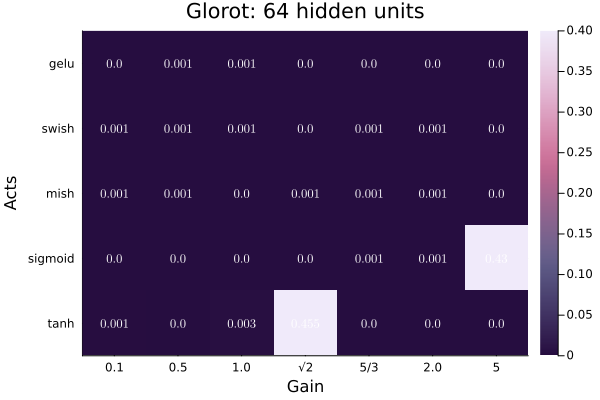

In [29]:
gain_str = ["0.1", "0.5", "1.0", "√2", "5/3", "2.0", "5"]
hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hg 

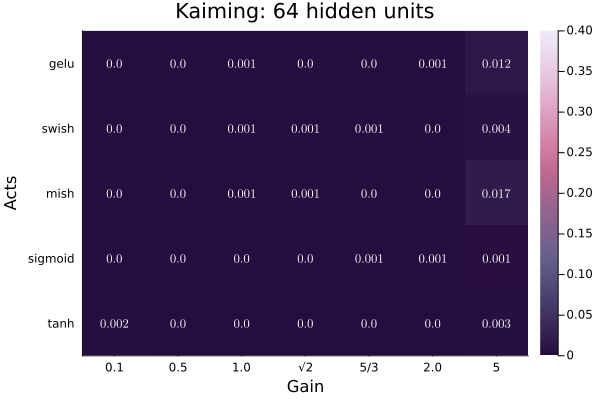

In [30]:
hk = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk 

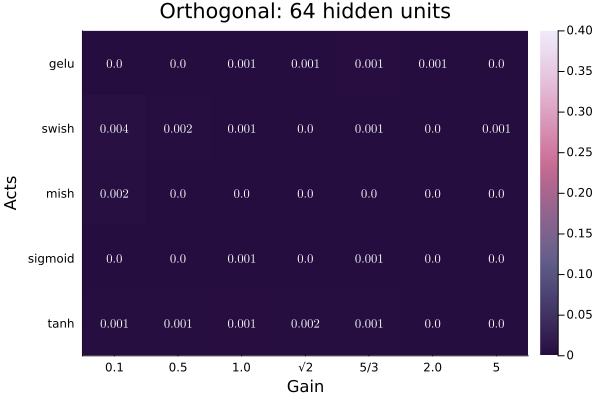

In [31]:
ho = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orthogonal: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho 

<p style="font-family:Times New Roman; font-size:120%">
    Absolutely every single combination has converged. These results are extremely good, and show the advantages of pre-training very clearly. This is also a very clear sign that it is indeed the initial network output that is affecting whether the models converge or not. No changes has been made to the training-data, network, or training hyper-parameters. Lastly I include a few plots displaying what pre-training is doing, and what the difference between pre-training vs not pre-training is for the exact same model.
</p>

Epoch=200 :loss = 0.52282614
Epoch=400 :loss = 0.49844414
Epoch=600 :loss = 0.47525436
Epoch=800 :loss = 0.45485467
Epoch=1000 :loss = 0.43834934


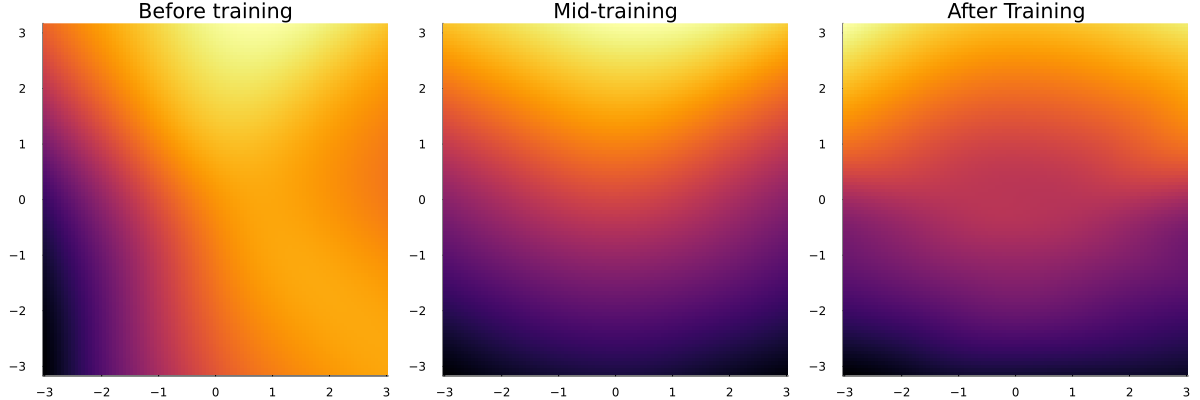

In [32]:
_, LuxH = models(2, 64, mish, Kaiming(1),1) #Fetch models
pHNN, sHNN = Lux.setup(Random.MersenneTwister(3), LuxH) 

smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap(p,q, layout=(1,3),reshape(est, 100, 100),title="Before training",size=(1200, 400),cbar=false)

pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=3,rng_nr=3)
smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="Mid-training",cbar=false)

pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=3)
smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="After Training",cbar=false)

Epoch=200 :loss = 0.0011253194
Epoch=400 :loss = 0.00073610427
Epoch=600 :loss = 0.0005704584
Epoch=800 :loss = 0.00051630463
Epoch=1000 :loss = 0.0004830075


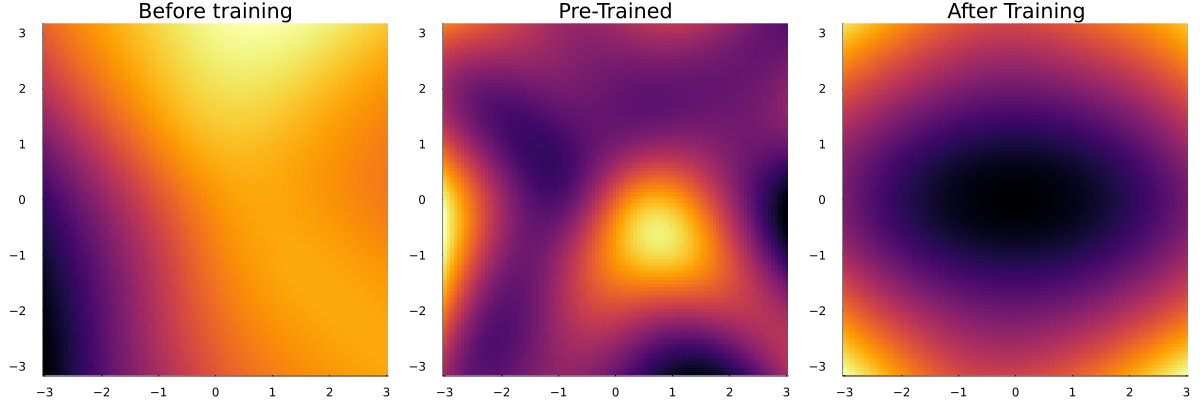

In [33]:
_, LuxH = models(2, 64, mish, Kaiming(1),1) #Fetch models
pHNN, sHNN = Lux.setup(Random.MersenneTwister(3), LuxH) 

smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap(p,q, layout=(1,3),reshape(est, 100, 100),title="Before training",size=(1200, 400),cbar=false)

pHNN, sHNN = Pre_training(LuxH,pHNN,sHNN)
smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="Pre-Trained",cbar=false)

pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=3,pretrain=true)
smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="After Training",cbar=false)